# dependencias

In [55]:
from youtube_transcript_api import YouTubeTranscriptApi
import youtube_dl
import re
import nltk
import matplotlib.pyplot as plt
from collections import Counter
import networkx as nx
from wordcloud import WordCloud
from itertools import combinations
import igraph as ig
import pandas as pd
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
from tqdm import tqdm
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bcriv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bcriv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 1. Introduccion  

## 1.1 descipcion del caso, el numero de videos, palabras luedo de la limpieza 


# tokenizacion 

## 2.1 importacion del texto 

In [56]:
# leer los txt
with open('../input/caso_6.txt', 'r') as f:
    subtitulos_caso_6 = f.read()
with open('../input/caso_7_1.txt', 'r') as f:
    subtitulos_caso_7_lista1 = f.read()
with open('../input/caso_7_2.txt', 'r') as f:
    subtitulos_caso_7_lista2 = f.read()
with open('../input/caso_7_3.txt', 'r') as f:
    subtitulos_caso_7_lista3 = f.read()
subtitulos_caso_7 = '\n'.join([subtitulos_caso_7_lista1,subtitulos_caso_7_lista2,subtitulos_caso_7_lista3])

## 2.2 nomalizacion de los datos

### Funciones necesarias

In [57]:
def normalizacion_regex_texto(texto):
    # Eliminar caracteres o palabras entre [] y ()
    texto = re.sub(r'\[.*?\]', '', texto)
    texto = re.sub(r'\(.*?\)', '', texto)
    # eliminar letras individuales 
    texto = re.sub(r'\b\w\b', '', texto)
    # minimizar, limpieza de espacios, eliminacion de puntuacion  
    palabras = nltk.tokenize.word_tokenize(texto)
    palabras = [palabra.lower() for palabra in palabras if palabra.isalpha()]
    texto = ' '.join(palabras)
    # eliminar acentos o tildes
    texto = re.sub(r'[áéíóúÁÉÍÓÚ]', lambda x: 'aeiouAEIOU'['áéíóúÁÉÍÓÚ'.index(x.group(0))], texto)
    
    return texto

def contar_palabras_con_numeros(texto):
    # Encuentra todas las palabras que contienen al menos un número
    palabras_con_numeros = re.findall(r'\b\w*\d\w*\b', texto)
    
    # Inicializa un diccionario para el conteo de palabras
    conteo_palabras = {}
    
    # Itera sobre las palabras encontradas y cuenta cada una
    for palabra in palabras_con_numeros:
        if palabra in conteo_palabras:
            conteo_palabras[palabra] += 1
        else:
            conteo_palabras[palabra] = 1
    return conteo_palabras

def eliminar_texto_con_numeros(texto):
    texto = re.sub(r'\b\w*\d\w*\b', '', texto)
    return texto

def eliminar_stop_words(texto,stop_words):
    '''eliminar stopwords'''
    palabras = texto.split()
    palabras = [word for word in palabras if word not in stop_words]
    texto = ' '.join(palabras)
    return texto

### implementacion

In [58]:
# conteo de palabras
conteo_palabras_caso_6 = contar_palabras_con_numeros(subtitulos_caso_6[0])
# eliminar texto con numeros
subtitulos_caso_6= eliminar_texto_con_numeros(subtitulos_caso_6.replace('\n',' '))
# normalizar texto
subtitulos_caso_6 = normalizacion_regex_texto(subtitulos_caso_6)
# eliminar stopwords
## cargamos las palabras 
with open('../input/stop_words_taller4.txt','r') as f:
    stop_words = f.read().splitlines()
subtitulos_caso_6 = eliminar_stop_words(subtitulos_caso_6,stop_words)

In [59]:
# conteo de palabras
conteo_palabras_caso_7 = contar_palabras_con_numeros(subtitulos_caso_7[0])
# eliminar texto con numeros
subtitulos_caso_7= eliminar_texto_con_numeros(subtitulos_caso_7.replace('\n',' '))
# normalizar texto
subtitulos_caso_7 = normalizacion_regex_texto(subtitulos_caso_7)
# eliminar stopwords
## cargamos las palabras 
with open('../input/stop_words_taller4.txt','r') as f:
    stop_words = f.read().splitlines()
subtitulos_caso_7 = eliminar_stop_words(subtitulos_caso_7,stop_words)

In [60]:
print(len(subtitulos_caso_7),len(subtitulos_caso_6),sep='\n') # 6/7/7/7

3353865
1483891


## 2.3 analisis de frecuencias

### funciones necesarias

In [61]:
def plot_top_words(text, num_words=100, bar_color='blue'):
    '''Genera un gráfico de barras con las palabras más comunes en un texto luego de ser limpiado y tokenizado.'''
    # separar el texto en palabras
    words = text.split(' ')
    words = [word.lower() for word in words if word.isalpha()]
    # Contar la frecuencia de cada palabra
    word_freq = Counter(words)

    # Obtener las palabras más comunes
    top_words = word_freq.most_common(num_words)

    # Preparar datos para el gráfico
    words, freq = zip(*top_words)
    
    # Crear el gráfico de barras con el color especificado
    plt.figure(figsize=(12, 5))
    plt.barh(range(len(words)), freq, align='center', color=bar_color)
    plt.yticks(range(len(words)), words)
    plt.gca().invert_yaxis()  # Invertir el eje y para que las palabras más comunes estén en la parte superior
    plt.xlabel('Frecuencia')
    plt.ylabel('Palabra')
    plt.title(f'Top {num_words} palabras más usadas')
    plt.show()


def plot_wordcloud(text, max_words=10, color='Accent'):
    # Genera un contador de las palabras en el texto
    word_counts = Counter(text.split())

    # Obtiene las 'max_words' palabras más comunes
    most_common_words = dict(word_counts.most_common(max_words))

    # Genera la nube de palabras con un solo color
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color).generate_from_frequencies(most_common_words)

    # Crea la figura de Matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

### implementacion

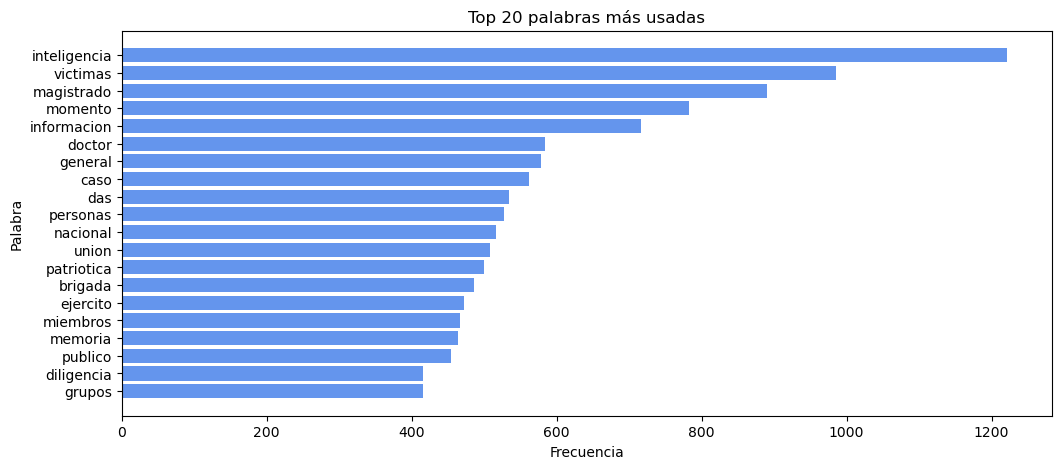

In [62]:
plot_top_words(subtitulos_caso_6,20,'cornflowerblue')

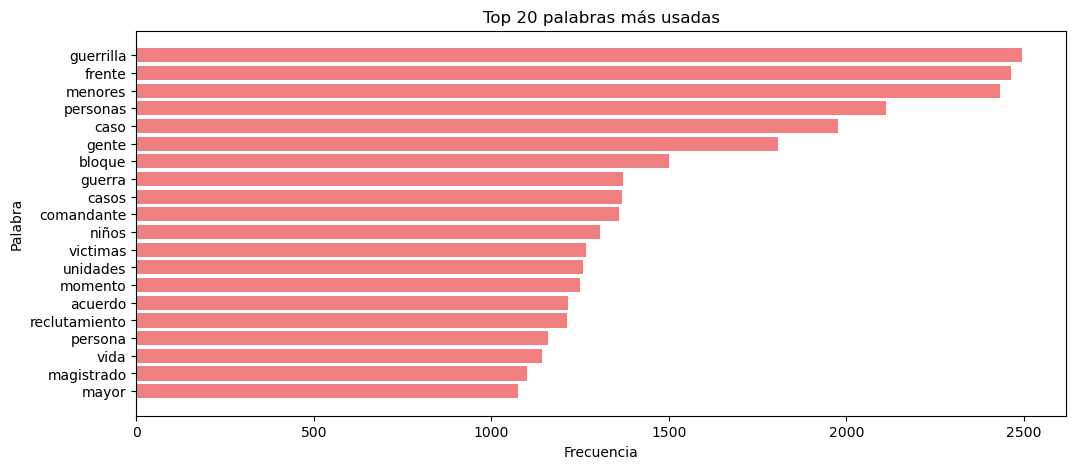

In [63]:
plot_top_words(subtitulos_caso_7,20,'lightcoral')

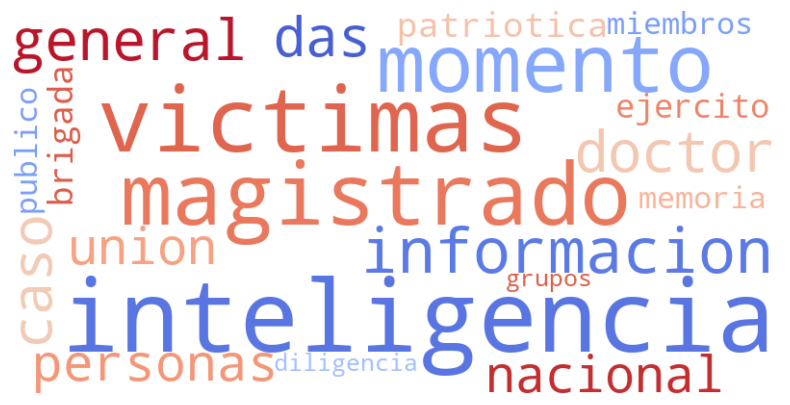

In [64]:
plot_wordcloud(subtitulos_caso_6, max_words=20, color= 'coolwarm')

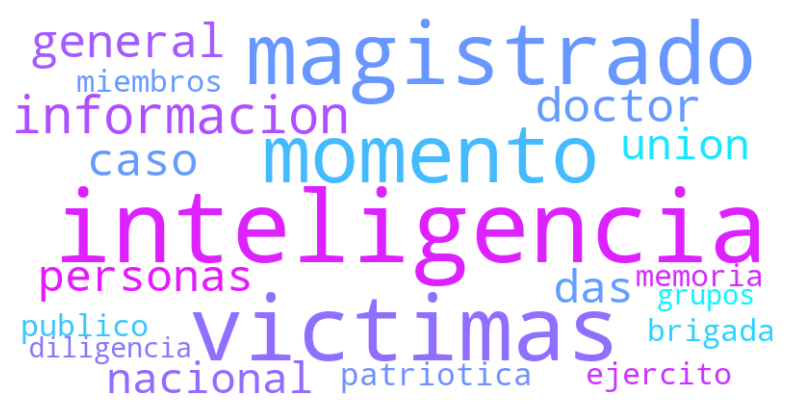

In [65]:
plot_wordcloud(subtitulos_caso_6, max_words=20, color='cool')

## 2.5 Correlacion de entre los casos

### funciones necesarias

In [66]:
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
import pandas as pd
import numpy as np
from tqdm import tqdm

def contar_apariciones(str1, str2):
    return _contar_apariciones_general(str1, str2)

def contar_apariciones_dos_textos(str1, str2):
    return _contar_apariciones_general(str1, str2, common_only=True)

def _contar_apariciones_general(str1, str2, common_only=False):
    # Dividir las cadenas en palabras y convertirlas a minúsculas para evitar distinción entre mayúsculas y minúsculas
    palabras_str1 = str1.lower().split()
    palabras_str2 = str2.lower().split()
    
    # Contar las apariciones de palabras en cada cadena
    contador_str1 = Counter(palabras_str1)
    contador_str2 = Counter(palabras_str2)
    
    # Obtener un conjunto único de todas las palabras
    palabras_totales = set(palabras_str1).union(set(palabras_str2))
    
    # Si solo queremos palabras comunes, utilizar intersección en lugar de unión
    if common_only:
        palabras_totales = set(palabras_str1).intersection(set(palabras_str2))
    
    # Inicializar un diccionario para contar las apariciones de cada palabra en cada cadena
    contador = defaultdict(lambda: {'Frecuencia en str1': 0, 'Frecuencia en str2': 0})
    for palabra in tqdm(palabras_totales, desc="Procesando palabras"):
        contador[palabra]['Frecuencia en str1'] = contador_str1[palabra] / len(palabras_str1)
        contador[palabra]['Frecuencia en str2'] = contador_str2[palabra] / len(palabras_str2)
    
    # Crear DataFrame
    df = pd.DataFrame.from_dict(contador, orient='index').reset_index()
    df.columns = ['Palabra', 'Frecuencia en str1', 'Frecuencia en str2']
    
    return df

### implementacion

In [67]:
resultado_1 = contar_apariciones(subtitulos_caso_6, subtitulos_caso_7)
# Usar la función contar_apariciones_dos_textos
resultado_2 = contar_apariciones_dos_textos(subtitulos_caso_6, subtitulos_caso_7)


Procesando palabras: 100%|██████████| 10663/10663 [00:00<00:00, 139779.98it/s]


In [83]:
resultado_1

,Palabra,Frecuencia en str1,Frecuencia en str2
0,dejarlo,0.000028,0.000028
1,numer,0.000006,0.000005
2,marco,0.000576,0.000445
3,repentina,0.000006,0.000000
4,ab,0.000006,0.000015
...,...,...,...
31239,embargo,0.000479,0.000563
31240,suicido,0.000006,0.000015
31241,poquitico,0.000000,0.000015
31242,truncados,0.000011,0.000000


In [84]:
resultado_2

,Palabra,Frecuencia en str1,Frecuencia en str2
0,dejarlo,0.000028,0.000028
1,numer,0.000006,0.000005
2,marco,0.000576,0.000445
3,publica,0.000741,0.000677
4,ab,0.000006,0.000015
...,...,...,...
10658,voluntad,0.000108,0.000275
10659,suicido,0.000006,0.000015
10660,orrego,0.000017,0.000010
10661,olvidado,0.000034,0.000008
